# Topics
1. Options for data cleaning:
    
    a. use top amenities as dummies
    
    b. remove amenities, transp, units, stories
    
    c. change year built to age
    
    d. defferent type of listings, prices varies a lot by leasing and purchasing


2. get yelp data or inspection data
    
    a. business data: rating, price level, inspection grade
    
    
    
3. Merge data by geo-zones

In [1]:
import pandas as pd
import numpy as np

In [2]:
bio = pd.read_csv("housing/building_bio.csv")

In [3]:
units = pd.read_csv("housing/units.csv")

In [4]:
building = pd.read_csv("housing/building.csv")

In [5]:
inspection = pd.read_csv("clean_inspection.csv")

/anaconda3/envs/ads/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Inspection Data

In [6]:
inspection.head()

,Unnamed: 0,CAMIS,DBA,BORO,BUILDING,STREET,ZIPCODE,PHONE,CUISINE DESCRIPTION,INSPECTION DATE,ACTION,VIOLATION CODE,VIOLATION DESCRIPTION,CRITICAL FLAG,SCORE,GRADE,GRADE DATE,RECORD DATE,INSPECTION TYPE
0,0,30075445,MORRIS PARK BAKE SHOP,BRONX,1007,MORRIS PARK AVE,10462.0,7188924968,Bakery,05/11/2018,Violations were cited in the following area(s).,08C,Pesticide use not in accordance with label or ...,Not Critical,5.0,A,05/11/2018,04/23/2019,Cycle Inspection / Initial Inspection
1,1,30075445,MORRIS PARK BAKE SHOP,BRONX,1007,MORRIS PARK AVE,10462.0,7188924968,Bakery,05/11/2018,Violations were cited in the following area(s).,10F,Non-food contact surface improperly constructe...,Not Critical,5.0,A,05/11/2018,04/23/2019,Cycle Inspection / Initial Inspection
2,2,30075445,MORRIS PARK BAKE SHOP,BRONX,1007,MORRIS PARK AVE,10462.0,7188924968,Bakery,05/18/2017,Violations were cited in the following area(s).,06D,"Food contact surface not properly washed, rins...",Critical,7.0,A,05/18/2017,04/23/2019,Cycle Inspection / Initial Inspection
3,3,30075445,MORRIS PARK BAKE SHOP,BRONX,1007,MORRIS PARK AVE,10462.0,7188924968,Bakery,05/18/2017,Violations were cited in the following area(s).,10F,Non-food contact surface improperly constructe...,Not Critical,7.0,A,05/18/2017,04/23/2019,Cycle Inspection / Initial Inspection
4,4,30075445,MORRIS PARK BAKE SHOP,BRONX,1007,MORRIS PARK AVE,10462.0,7188924968,Bakery,02/18/2016,Violations were cited in the following area(s).,04L,Evidence of mice or live mice present in facil...,Critical,10.0,A,02/18/2016,04/23/2019,Cycle Inspection / Initial Inspection


In [7]:
# only need the zipcoed for merge and the score for the model
inspection = inspection[['ZIPCODE', 'SCORE']].copy()
inspection = inspection.dropna()

In [8]:
inspection['SCORE'].describe()

count    355435.000000
mean         19.854558
std          14.160249
min          -1.000000
25%          11.000000
50%          15.000000
75%          25.000000
max         156.000000
Name: SCORE, dtype: float64

In [9]:
# map the score to non-negative floats
inspection['SCORE'] = inspection['SCORE'].map(lambda x: 0 if x==-1 else float(x))

In [10]:
# group by zipcode and take the average of the score
inspection = inspection.groupby('ZIPCODE', as_index=False).mean()

In [11]:
inspection.head()

,ZIPCODE,SCORE
0,10000.0,16.666667
1,10001.0,19.504966
2,10002.0,22.023928
3,10003.0,19.883718
4,10004.0,17.659234


# Unit Data

In [12]:
units.head()

,unit,status,no_rooms,no_bath,area(ftsq),id
0,#3,"Off-Market on 10/12/2010 at $1,650",studio,1 bath,NaN,73971
1,#4,"Off-Market on 08/22/2018 at $10,250",2 beds,3 baths,"2,000 ftsq",73971
2,#1,"Off-Market on 10/18/2018 at $5,995",2 beds,1 bath,"1,100 ftsq",786613
3,#2,"Listed for rent at $6,500",2 beds,1 bath,"1,200 ftsq",786613
4,#3,"Off-Market on 02/15/2011 at $5,400",2 beds,1 bath,"1,200 ftsq",786613


In [13]:
units.shape

(24046, 6)

In [14]:
temp = units.copy()

In [15]:
# remove the off-market units and convert the price to numeric values
temp['status'] = temp['status'].map(lambda x: int((x.split("$")[1]).replace(",","")) if x!= "Off-Market" else None)
temp['status'] = temp['status'].replace(0, None)
temp = temp.dropna()

In [16]:
# convert the area to numeric values
temp['area(ftsq)'] = temp['area(ftsq)'].map(lambda  x: int((x.split(" ")[0]).replace(",","")) if x!=None else None)
temp = temp.dropna()

In [17]:
temp['status'].describe()

count    1.255700e+04
mean     1.011494e+06
std      4.032970e+06
min      1.000000e+00
25%      3.400000e+03
50%      5.225000e+03
75%      8.690000e+05
max      7.312349e+07
Name: status, dtype: float64

In [18]:
temp['area(ftsq)'].describe()

count    12557.000000
mean      1171.991797
std       1219.696323
min          1.000000
25%        660.000000
50%        866.000000
75%       1350.000000
max      94361.000000
Name: area(ftsq), dtype: float64

In [19]:
temp.shape

(12557, 6)

In [20]:
len(temp.id.unique())

465

In [21]:
temp['no_bath'].unique()

array(['3 baths', '1 bath', '4 baths', '5 baths', '7 baths', '2.5 baths',
       '2 baths', '3.5 baths', '1.5 baths', '4.5 baths', '5+ baths',
       '6+ baths', '6 baths', '7.5 baths', '7+ baths', '6.5 baths',
       '8 baths', '2+ baths', '18 baths', '4+ baths', '0.5 baths',
       '8+ baths', '5.5 baths', '12 baths', '15+ baths', '10 baths',
       '9 baths', '3+ baths', '1+ bath'], dtype=object)

In [22]:
temp['no_rooms'].unique()

array(['2 beds', '5 beds', '1 bed', '6 beds', 'studio', '3 beds',
       '4 beds', '2.5 beds', '1.2 beds', '1.5 beds', '7 beds', '50 beds',
       '3.5 beds', '8 beds', '18 beds', '20 beds', '13 beds', '4.5 beds',
       '10 beds'], dtype=object)

In [23]:
def toNum(x):
    x = x.split(" ")[0]
    try:
        return float(x)
    except ValueError:
        #print(x)
        return float(x[0])

In [24]:
# convert number of bedrooms and number of bathrooms to numeric
temp['no_rooms'] = temp['no_rooms'].map(lambda x: toNum(x) if x!='studio' else 0)
temp['no_bath'] = temp['no_bath'].map(lambda x: toNum(x))

In [25]:
temp = temp.dropna()

## Plot the labels, could be normalized to guassian

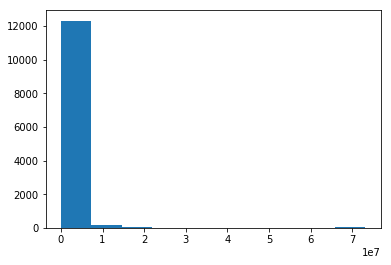

In [26]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(temp["status"], bins=10)
plt.show()

/anaconda3/envs/ads/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log
  """Entry point for launching an IPython kernel.
/anaconda3/envs/ads/lib/python3.6/site-packages/numpy/lib/histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/anaconda3/envs/ads/lib/python3.6/site-packages/numpy/lib/histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


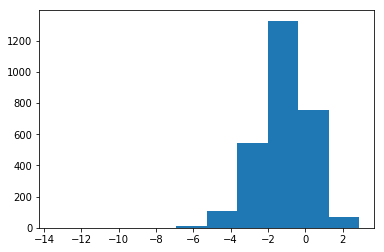

In [27]:
plt.hist(np.log((temp["status"]-temp["status"].mean())/temp['status'].std()), bins=10)
plt.show()

In [28]:
units = temp.copy()

# Building data

In [29]:
building.head()

,Unnamed: 0,id,bldname,address,type,top_amenity,amenities,transp1,transp2,transp3,transp4,transp5,units,stories,year
0,0,70863,Building: 226 West Broadway,"226 West Broadway, New York, NY, 10013",Rental Building,NaN,['NYC Storm Zone 2'],1at Franklin St under 500 feet,ACEat Canal St 0.11 miles,1at Canal St 0.22 miles,JNQRZ6Wat Canal St 0.23 miles,ACE123at Chambers St 0.41 miles,1 unit,4 stories,Built in 1915
1,1,70863,Building: 226 West Broadway,"226 West Broadway, New York, NY, 10013",Rental Building,NaN,['NYC Storm Zone 2'],1at Franklin St under 500 feet,ACEat Canal St 0.11 miles,1at Canal St 0.22 miles,JNQRZ6Wat Canal St 0.23 miles,ACE123at Chambers St 0.41 miles,1 unit,4 stories,Built in 1915
2,2,70872,Building: 428 Greenwich Street,"428 Greenwich Street, New York, NY, 10013",Mixed-Use Building,NaN,['NYC Storm Zone 1'],1at Canal St 0.2 miles,ACEat Canal St 0.26 miles,1at Franklin St 0.29 miles,CEat Spring St 0.39 miles,JNQRZ6Wat Canal St 0.45 miles,2 units,5 stories,Built in 1915
3,3,70962,Building: 154 Stanton Street,"154 Stanton Street, New York, NY, 10002",Co-op,NaN,"['Pied-a-Terre Allowed', 'Sublets Allowed', 'N...",FJMZat Delancey St-Essex St 0.19 miles,Fat 2nd Av 0.25 miles,JZat Bowery 0.45 miles,BDat Grand St 0.47 miles,Fat East Broadway 0.5 miles,1 unit,2 stories,Built in 1920
4,4,70962,Building: 154 Stanton Street,"154 Stanton Street, New York, NY, 10002",Co-op,NaN,"['Pied-a-Terre Allowed', 'Sublets Allowed', 'N...",FJMZat Delancey St-Essex St 0.19 miles,Fat 2nd Av 0.25 miles,JZat Bowery 0.45 miles,BDat Grand St 0.47 miles,Fat East Broadway 0.5 miles,1 unit,2 stories,Built in 1920


In [30]:
building.shape

(1000, 15)

In [31]:
# take the columns needed and convert to numeric values
temp = building[['id', 'address', 'type', 'top_amenity', 'units', 'stories', 'year']].copy()
temp = temp.dropna()
temp["zip"] = temp['address'].map(lambda x: float(x.split(',')[3]))
temp["age"] = 2019 - temp["year"].map(lambda x: int(x.split(' ')[2]))
temp[['units', 'stories']] = temp[['units', 'stories']].applymap(lambda x: int(x.split(' ')[0]))

In [32]:
# create dummy variables to apartment type
dummies = pd.get_dummies(temp['type'])
temp = pd.concat([temp, dummies], axis=1)

In [33]:
# create dummy variables for each top amenity type
temp["top_amenity"] = temp["top_amenity"].astype(str)
ls = temp["top_amenity"].unique()
ss = set()
for s in ls:
    ls2 = s.replace("\'","").replace("[","").replace("]","").split(',')
    for c in ls2:
        if c[0] == ' ': c=c[1:]
        ss.add(c)
print(ss)
for s in ss:
    temp[s] = temp["top_amenity"].str.contains(s).astype(int)

{'Doorman', 'Full-time Doorman', 'Elevator', 'Part-time Doorman', 'Cats and Dogs Allowed', 'Cats Only - No Dogs', 'Pets Allowed'}


In [34]:
temp = temp.drop(['address', 'top_amenity', 'type', 'year'], axis=1)

In [35]:
temp.head()

,id,units,stories,zip,age,Co-op,Condo,Rental Building,Single-Family Home,Doorman,Full-time Doorman,Elevator,Part-time Doorman,Cats and Dogs Allowed,Cats Only - No Dogs,Pets Allowed
11,71007,5,6,10009.0,12,0,1,0,0,0,0,1,0,1,0,0
19,71093,1,4,10003.0,120,0,0,0,1,1,0,1,0,0,0,0
20,71093,1,4,10003.0,120,0,0,0,1,1,0,1,0,0,0,0
74,72297,2,4,10016.0,99,1,0,0,0,0,0,1,0,0,0,0
85,72483,355,36,10016.0,45,0,0,1,0,1,0,1,0,0,0,0


In [36]:
building = temp.copy()

# Merge Data

In [37]:
inspection.columns

Index(['ZIPCODE', 'SCORE'], dtype='object')

In [38]:
building.columns

Index(['id', 'units', 'stories', 'zip', 'age', 'Co-op', 'Condo',
       'Rental Building', 'Single-Family Home', 'Doorman', 'Full-time Doorman',
       'Elevator', 'Part-time Doorman', 'Cats and Dogs Allowed',
       'Cats Only - No Dogs', 'Pets Allowed'],
      dtype='object')

In [39]:
units.columns

Index(['unit', 'status', 'no_rooms', 'no_bath', 'area(ftsq)', 'id'], dtype='object')

In [40]:
units.shape

(12557, 6)

In [41]:
building.shape

(247, 16)

In [42]:
m1 = pd.merge(left=units, right=building, left_on='id', right_on='id', how='left')

In [43]:
m2 = pd.merge(left=m1, right=inspection, left_on='zip', right_on='ZIPCODE', how='left')

In [44]:
res = m2.dropna()

# Output

In [45]:
res.to_csv("building_units_inspection.csv",index_label=False)